In [1]:
from sklearn.cluster import KMeans
import torch
from torch.nn import Embedding
from torch.utils.data import DataLoader
import torch.nn as nn
EPS = 1e-15
from torch.nn import Parameter
import pandas as pd
import numpy as np
device = 'cpu'
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from torch_geometric.datasets import Planetoid
import copy
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.datasets import KarateClub

In [2]:
def predict_auc(recons_edges, true_edges):
    predict_graph = recons_edges
    predict_edges = np.array(predict_graph)
    #print("AP SCORE： ",average_precision_score(true_edges, predict_edges))
    #print("AUC SCORE: ",roc_auc_score(true_edges, predict_edges))
    return average_precision_score(true_edges, predict_edges), roc_auc_score(true_edges, predict_edges)

In [3]:
nodes_embedding = pd.read_excel("karate_nodes.xlsx", header=None)
nodes_embedding = torch.from_numpy(np.array(nodes_embedding))

cluster_centers = pd.read_excel("karate_clusters.xlsx", header=None)
cluster_centers = torch.from_numpy(np.array(cluster_centers))

In [4]:
nodes_embedding.shape, cluster_centers.shape

(torch.Size([34, 8]), torch.Size([12, 8]))

In [5]:
def computer_edge_prob(ne, cc):
    CC = cc
    NE = ne
    norm_squared = torch.sum((NE.unsqueeze(1) - CC)**2, 2)   
    numerator = 1.0 / (1.0 + (norm_squared / alpha))
    power = float(alpha + 1) / 2   
    numerator = numerator**power    
    soft_assignments = (numerator.t() / torch.sum(numerator, 1)).t() #soft assignment using t-distribution
    node_cluster = soft_assignments.argmax(1)    
    
    prod = torch.mm(soft_assignments, soft_assignments.t())
    norm = torch.norm(soft_assignments,p=2,dim=1).unsqueeze(0)
    clusters_similar = prod.div(torch.mm(norm.t(),norm))
    
    nodes_distance = torch.norm(NE[:, None]-NE, dim=2, p=2)
    nodes_distance = torch.div(nodes_distance, torch.max(nodes_distance))
    
    distance_similar = torch.div(beta*nodes_distance, clusters_similar)      
    nodes_similar = torch.exp(-distance_similar)
    nodes_similar = torch.div(nodes_similar, torch.max(nodes_similar))
    
#     recons_test_edges = torch.take(nodes_similar, test_mask).detach()
#     ap, auc = predict_auc(recons_test_edges, test_edge)
#     print("ap : ",ap)
#     print("auc : ",auc)
    return nodes_similar, node_cluster

In [6]:
alpha = 1.0
beta = 5
nodes_number = 34
similar, clusters = computer_edge_prob(nodes_embedding, cluster_centers)

In [7]:
s = copy.deepcopy(similar)

In [8]:
dataset = KarateClub()
data = dataset[0]
edges = data.edge_index
start_nodes = np.array(edges[0])
end_nodes = np.array(edges[1])

graph_np = np.zeros((nodes_number, nodes_number))

for i in range(edges.shape[1]):
    graph_np[start_nodes[i], end_nodes[i]]=1

In [9]:
graph_np

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [10]:
true_edges = graph_np.reshape(nodes_number*nodes_number)

In [11]:
for gama in [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]:
    print("gama : ",gama)
    nodes_s = copy.deepcopy(s)
    for i in range(nodes_s.shape[0]):
        nodes_s[i,i]=0
    nodes_s[nodes_s>gama] = 1
    nodes_s[nodes_s<=gama] = 0
    pred_edges = nodes_s.reshape(nodes_number*nodes_number)
    print("edges： ",pred_edges.sum())
    print("ACC SCORE： ",accuracy_score(true_edges, pred_edges))

gama :  0.2
edges：  tensor(246., dtype=torch.float64)
ACC SCORE：  0.9186851211072664
gama :  0.25
edges：  tensor(198., dtype=torch.float64)
ACC SCORE：  0.9532871972318339
gama :  0.3
edges：  tensor(172., dtype=torch.float64)
ACC SCORE：  0.9619377162629758
gama :  0.35
edges：  tensor(158., dtype=torch.float64)
ACC SCORE：  0.967128027681661
gama :  0.4
edges：  tensor(146., dtype=torch.float64)
ACC SCORE：  0.9602076124567474
gama :  0.45
edges：  tensor(132., dtype=torch.float64)
ACC SCORE：  0.9515570934256056
gama :  0.5
edges：  tensor(126., dtype=torch.float64)
ACC SCORE：  0.9463667820069204
gama :  0.55
edges：  tensor(116., dtype=torch.float64)
ACC SCORE：  0.9480968858131488
gama :  0.6
edges：  tensor(102., dtype=torch.float64)
ACC SCORE：  0.9394463667820069
gama :  0.65
edges：  tensor(92., dtype=torch.float64)
ACC SCORE：  0.9307958477508651
gama :  0.7
edges：  tensor(70., dtype=torch.float64)
ACC SCORE：  0.9117647058823529
gama :  0.75
edges：  tensor(50., dtype=torch.float64)
ACC SCORE

In [12]:
gama = 0.35
for i in range(s.shape[0]):
    s[i,i]=0
s[s>gama] = 1
s[s<=gama] = 0
predict_edges = s.reshape(nodes_number*nodes_number)
print("ACC： ",accuracy_score(true_edges, predict_edges))
print("AP： ",precision_score(true_edges, predict_edges, average='macro'))
print("RECALL： ",recall_score(true_edges, predict_edges, average='macro'))
print("F1 SCORE： ",f1_score(true_edges, predict_edges, average='macro'))

ACC：  0.967128027681661
AP：  0.9276908246873494
RECALL：  0.9323076923076923
F1 SCORE：  0.9299809363503632


In [13]:
nodes_similar = np.array(s)
clusters = np.array(clusters)

In [14]:
import networkx as nx
NS, NC = nodes_similar, clusters
print("edges： ",NS.sum())
G_predict=nx.from_numpy_array(NS)
node_cluster=list(NC)
node_dict={node:str(cluster) for node,cluster in enumerate(node_cluster)}
nx.set_node_attributes(G_predict,node_dict,'cluster')

dataset = KarateClub()
data = dataset[0]
edges = data.edge_index
start_nodes = np.array(edges[0])
end_nodes = np.array(edges[1])
graph_np = np.zeros((nodes_number, nodes_number))
for i in range(edges.shape[1]):
    graph_np[start_nodes[i], end_nodes[i]]=1
G_true=nx.from_numpy_array(graph_np)

edges：  158.0


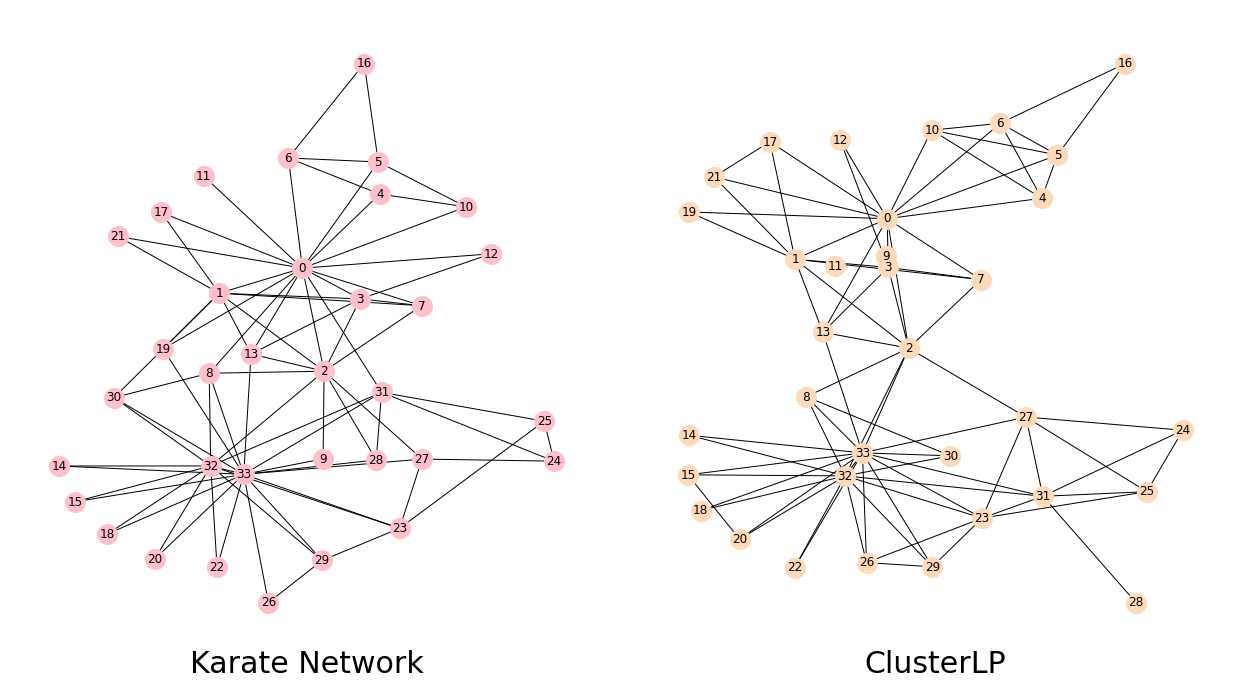

In [19]:
plt.figure(figsize=(22, 12))
plt.subplots_adjust(wspace=0.05)

grid=plt.GridSpec(1,2)

AX0 = plt.subplot(grid[0, 0])
true_pos=nx.kamada_kawai_layout(G_true)
nx.draw(G_true,true_pos,with_labels = True,node_color = 'pink',node_size = 400, width=1, ax=AX0)
plt.title("Karate Network", fontsize=30, y=-0.03)

AX1 = plt.subplot(grid[0, 1])
pre_pos=nx.kamada_kawai_layout(G_predict)
nx.draw(G_predict, pre_pos, with_labels=True, node_color='peachpuff', node_size = 400, width=1, ax=AX1)
plt.title("ClusterLP", fontsize=30, y=-0.03)

plt.savefig("reconed_karate_CLUSTERLP.pdf",bbox_inches='tight')
plt.show()

In [15]:
NECS_graph = pd.read_csv("NECS_recon_karate.txt", header=None, sep=' ')
NECS_graph = np.array(NECS_graph)
NECS_predict = nx.from_numpy_array(NECS_graph)

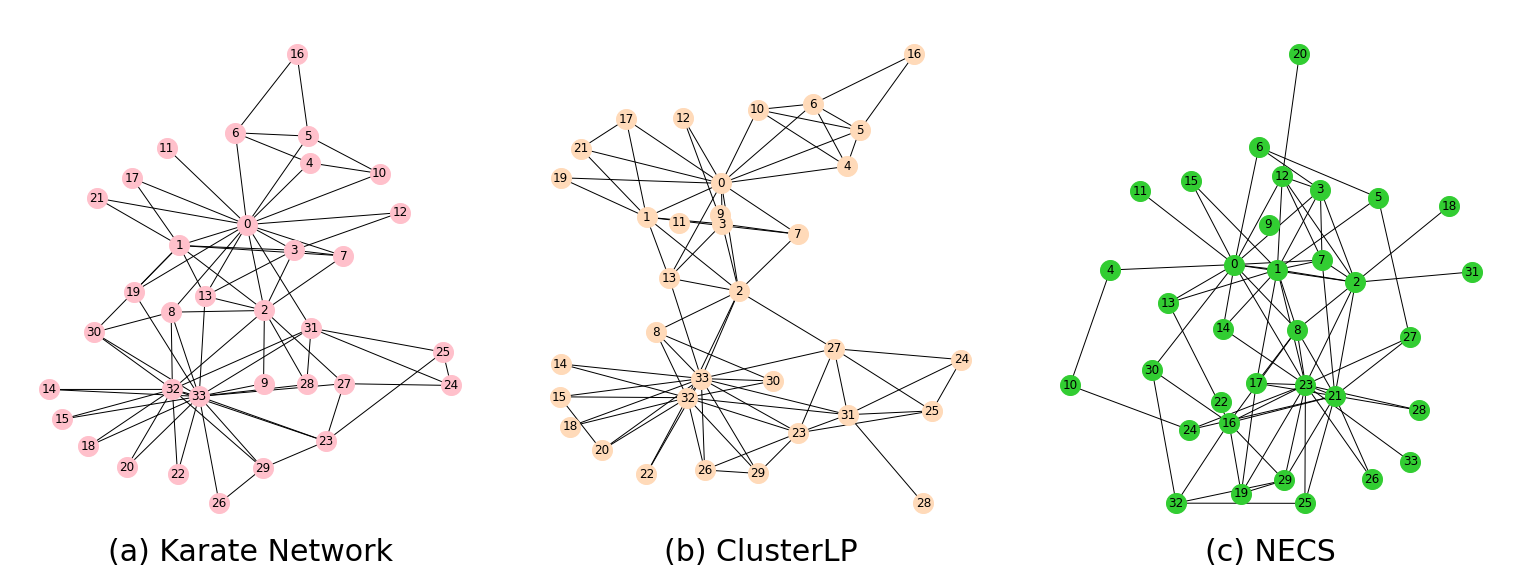

In [16]:
plt.figure(figsize=(27, 10))
plt.subplots_adjust(wspace=0.05)

grid=plt.GridSpec(1,3)

AX0 = plt.subplot(grid[0, 0])
true_pos=nx.kamada_kawai_layout(G_true)
nx.draw(G_true,true_pos,with_labels = True,node_color = 'pink',node_size = 400, width=1, ax=AX0)
plt.title("(a) Karate Network",fontsize=30,y=-0.03)

AX1 = plt.subplot(grid[0, 1])
pre_pos=nx.kamada_kawai_layout(G_predict)
nx.draw(G_predict, pre_pos, with_labels=True, node_color='peachpuff', node_size = 400, width=1, ax=AX1)
plt.title("(b) ClusterLP",fontsize=30,y=-0.03)

AX2 = plt.subplot(grid[0, 2])
NECS_pos = nx.kamada_kawai_layout(NECS_predict)
nx.draw(NECS_predict, NECS_pos, with_labels = True, node_color = 'limegreen', node_size = 400, width=1, ax=AX2)
plt.title("(c) NECS",fontsize=30,y=-0.03)

plt.savefig("reconed_karate.pdf",bbox_inches='tight')
plt.show()